In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'state-farm-distracted-driver-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5048%2F868335%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T083621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0fba3b3488f1a2b6852755a19dd944dd511b3ff4f0062ae7d2968e6a156f53b09597a3f518e894478ddae62b7f3e557938297fc59ba98e211e72d6843de0ff6d65543f866a79008a4c730ac450cc3fba905e3088dce86b8556ed2f76086f10abf20786d014c300c55136e1cb7680a1d41fbebb9814defb2c24f518cf17ceafb09853f201844d2bf0cbc80a24e86541fce1f0ba2168392781767d12dcdd0033b60dedd32f2e872afa69a3234fb5aa03f2c1da8eb645ec2bf78fef80237f8585ad8300e24f0649bcbc8730b086f3c51ff0266b43923a0b1ddde2b09cbc246f13e75ada032c0cf55b753970bd9ba27116d862c2eae5aba71f363df062f0d46faf3c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

## Data Preprocessing

In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Path to the training data directory
train_data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

# Get the list of class folders
class_folders = sorted(os.listdir(train_data_dir))

# Create a list to store image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for i, folder in enumerate(class_folders):
    # Get the list of image files in the folder
    folder_path = os.path.join(train_data_dir, folder)
    image_files = os.listdir(folder_path)

    # Add image paths and labels to the lists
    image_paths.extend([os.path.join(folder_path, img) for img in image_files])
    labels.extend([i] * len(image_files))  # Assign label based on folder index

# Split the data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create DataFrames for training and testing data
train_df = pd.DataFrame({'filename': train_files, 'label': train_labels})
test_df = pd.DataFrame({'filename': test_files, 'label': test_labels})

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Define image dimensions
img_width, img_height = 150, 150

# Create data generator for training set (without data augmentation)
train_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

# Create data generator for testing set
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')


Found 17939 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.


## Making sure that generators are working well

In [7]:
import matplotlib.pyplot as plt

def visualize_generator(generator, num_samples=9):
    """
    Visualize a batch of images generated by a Keras ImageDataGenerator.

    Args:
        generator: Keras ImageDataGenerator object.
        num_samples: Number of samples to visualize.
    """
    # Generate a batch of images and labels
    batch = generator.next()
    images = batch[0]
    labels = batch[1]

    # Get the class labels
    class_labels = list(generator.class_indices.keys())

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_labels[label_index])
        plt.axis('off')
    plt.show()


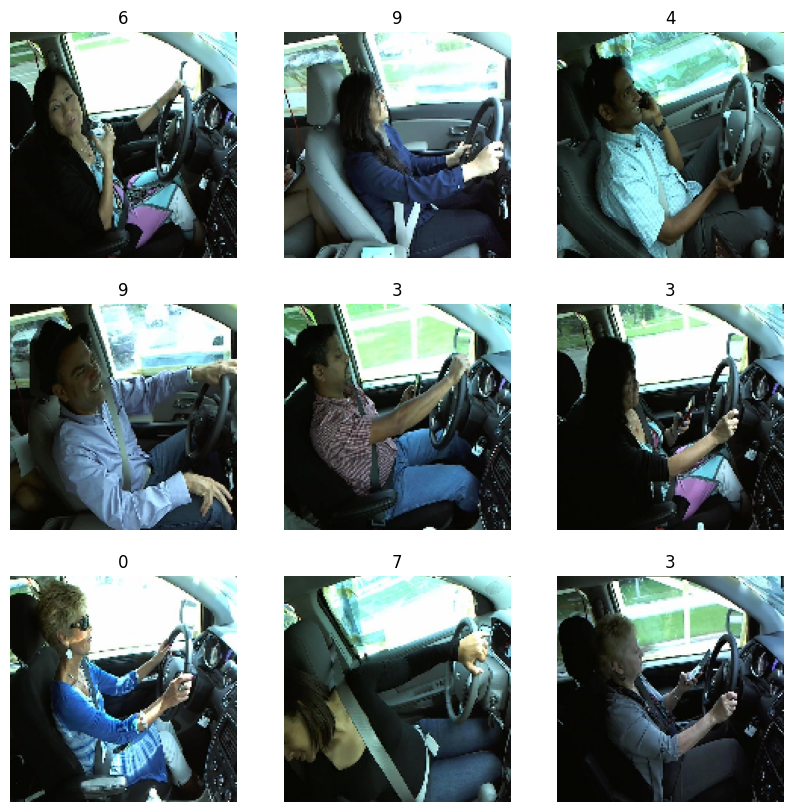

In [8]:
# Visualize training generator output
visualize_generator(train_generator)

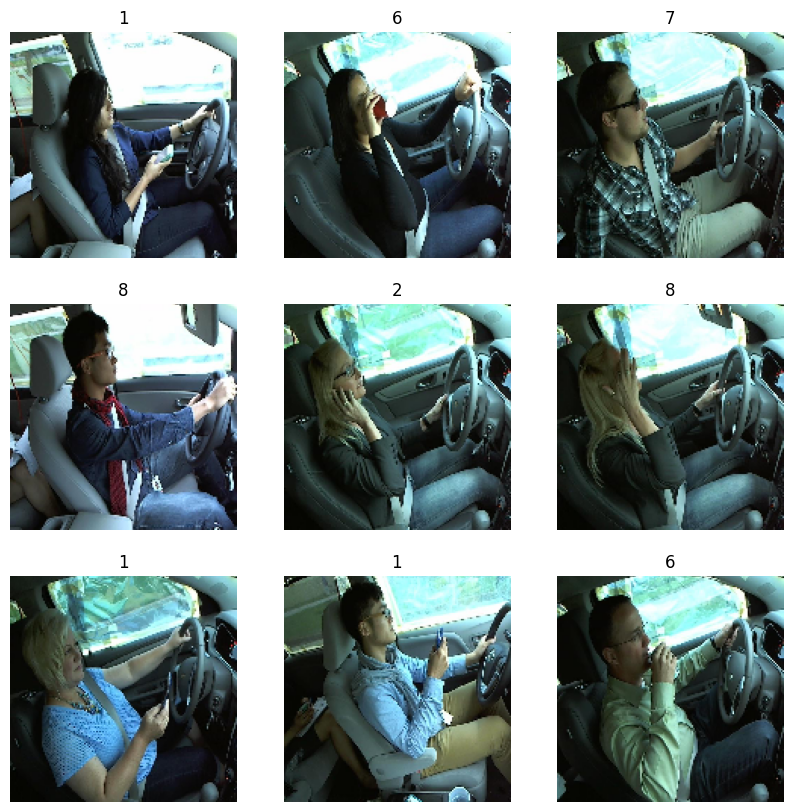

In [9]:
# Visualize testing generator output
visualize_generator(test_generator)

## Baseline Dense Model

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Define the model
model = Sequential([
    Flatten(input_shape=(img_width, img_height, 3)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/10
560/560 [==============================] - 55s 94ms/step - loss: 2.8448 - accuracy: 0.1811 - val_loss: 2.0169 - val_accuracy: 0.2214
Epoch 2/10
560/560 [==============================] - 52s 93ms/step - loss: 1.9856 - accuracy: 0.2193 - val_loss: 1.9037 - val_accuracy: 0.2520
Epoch 3/10
560/560 [==============================] - 54s 96ms/step - loss: 1.8745 - accuracy: 0.2486 - val_loss: 1.8382 - val_accuracy: 0.2922
Epoch 4/10
560/560 [==============================] - 53s 94ms/step - loss: 1.8076 - accuracy: 0.2751 - val_loss: 1.7472 - val_accuracy: 0.2897
Epoch 5/10
560/560 [==============================] - 64s 113ms/step - loss: 1.7078 - accuracy: 0.3135 - val_loss: 1.6652 - val_accuracy: 0.3473
Epoch 6/10
560/560 [==============================] - 52s 94ms/step - loss: 1.6519 - accuracy: 0.3336 - val_loss: 1.6144 - val_accuracy: 0.3933
Epoch 7/10
560/560 [==============================] - 53s 94ms/step - loss: 1.6032 - accuracy: 0.3491 - val_loss: 1.8537 - val_accuracy

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def evaluate_model(model, test_generator):
    # Evaluate the model on the testing data
    loss, accuracy = model.evaluate(test_generator)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')


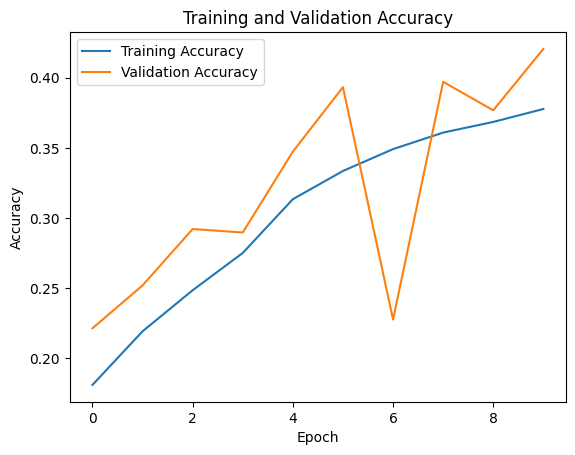

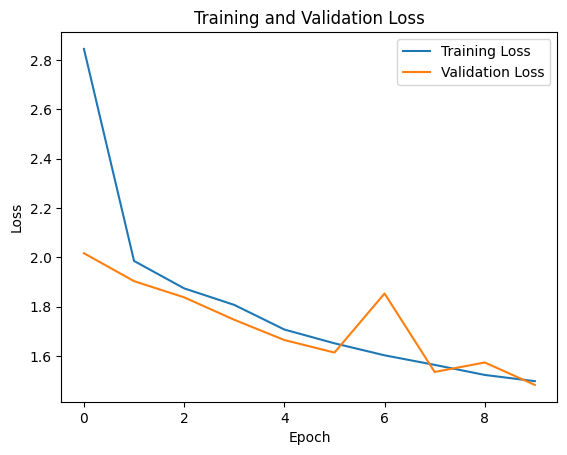

141/141 [==============================] - 11s 77ms/step - loss: 1.4835 - accuracy: 0.4203
Test Loss: 1.4835
Test Accuracy: 0.4203


In [ ]:
plot_history(history)

# Evaluate the model
evaluate_model(model, test_generator)

In [ ]:
## Baseline CNN Model

In [ ]:
# Define the model
model = Sequential([
    Flatten(input_shape=(img_width, img_height, 3)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/5
560/560 [==============================] - 146s 260ms/step - loss: 1.7371 - accuracy: 0.6074 - val_loss: 0.5736 - val_accuracy: 0.8239
Epoch 2/5
560/560 [==============================] - 148s 264ms/step - loss: 0.4088 - accuracy: 0.8806 - val_loss: 0.2748 - val_accuracy: 0.9143
Epoch 3/5
560/560 [==============================] - 129s 230ms/step - loss: 0.2144 - accuracy: 0.9386 - val_loss: 0.5003 - val_accuracy: 0.8342
Epoch 4/5
560/560 [==============================] - 130s 232ms/step - loss: 0.1374 - accuracy: 0.9595 - val_loss: 0.1040 - val_accuracy: 0.9719
Epoch 5/5
560/560 [==============================] - 137s 244ms/step - loss: 0.1363 - accuracy: 0.9583 - val_loss: 0.1391 - val_accuracy: 0.9576


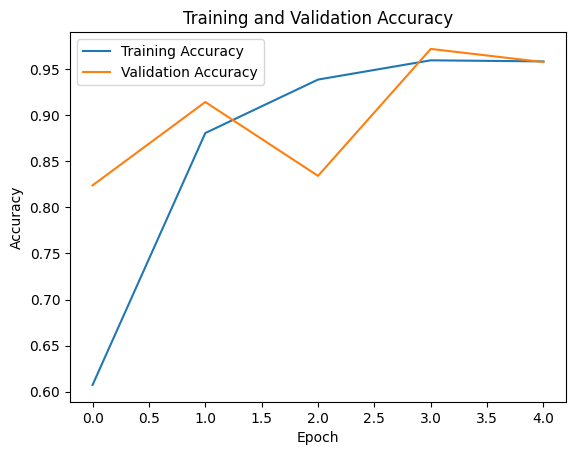

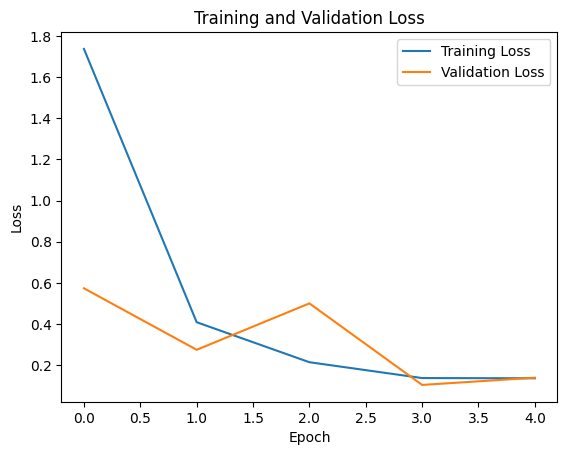

141/141 [==============================] - 16s 116ms/step - loss: 0.1390 - accuracy: 0.9576
Test Loss: 0.1390
Test Accuracy: 0.9576


In [ ]:
plot_history(history)

# Evaluate the model
evaluate_model(model, test_generator)


## Data Augmentation

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_width, img_height = 150, 150

# Create data generator for training set with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    dataframe=train_df,
    target_size=(img_width, img_height),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'
    )

test_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = test_datagen_augmented.flow_from_dataframe(
    dataframe=test_df,
    target_size=(img_width, img_height),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical')


Found 17939 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.


In [22]:
from keras.layers import Conv2D, MaxPooling2D
# Define and train the CNN model with data Daugmentation
model_cnn_augmented = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

model_cnn_augmented.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

history_cnn_augmented = model_cnn_augmented.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // train_generator_augmented.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)



Epoch 1/10
560/560 [==============================] - 173s 299ms/step - loss: 2.1331 - accuracy: 0.2013 - val_loss: 1.6996 - val_accuracy: 0.3757
Epoch 2/10
560/560 [==============================] - 167s 298ms/step - loss: 1.3544 - accuracy: 0.5144 - val_loss: 1.1200 - val_accuracy: 0.6214
Epoch 3/10
560/560 [==============================] - 167s 299ms/step - loss: 0.8702 - accuracy: 0.6995 - val_loss: 0.7192 - val_accuracy: 0.7647
Epoch 4/10
560/560 [==============================] - 164s 292ms/step - loss: 0.6211 - accuracy: 0.7930 - val_loss: 0.5598 - val_accuracy: 0.8150
Epoch 5/10
560/560 [==============================] - 175s 313ms/step - loss: 0.5010 - accuracy: 0.8346 - val_loss: 0.4504 - val_accuracy: 0.8504
Epoch 6/10
560/560 [==============================] - 175s 312ms/step - loss: 0.4199 - accuracy: 0.8621 - val_loss: 0.4010 - val_accuracy: 0.8636
Epoch 7/10
560/560 [==============================] - 164s 293ms/step - loss: 0.3635 - accuracy: 0.8792 - val_loss: 0.3305 -

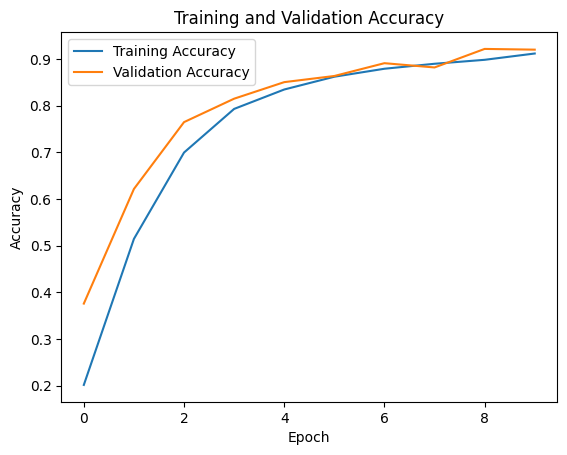

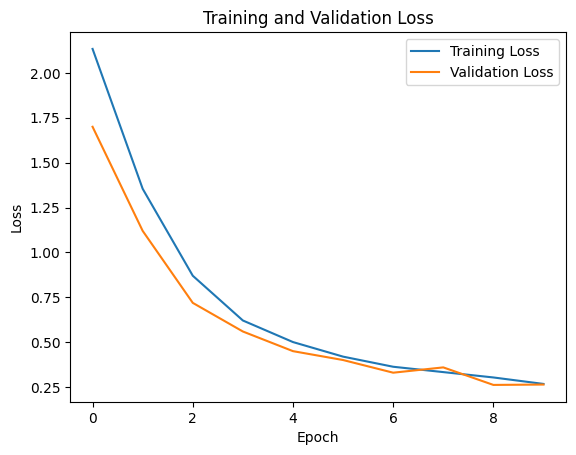

141/141 [==============================] - 33s 236ms/step - loss: 0.2640 - accuracy: 0.9148
Test Loss: 0.2640
Test Accuracy: 0.9148


In [25]:
# Plot training history
plot_history(history_cnn_augmented)

# Evaluate the model
evaluate_model(model_cnn_augmented, test_generator)


## Transfer Learning

In [26]:
# instantiating the VGG16 model:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [27]:
from tensorflow.keras import optimizers

# Building the model
model_vgg16 = models.Sequential()
model_vgg16.add(conv_base)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(10, activation='softmax'))

model_vgg16.compile(optimizer=optimizers.Adam(0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [28]:
model_vgg16.compile(optimizer=optimizers.Adam(0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [29]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_vgg16 .trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [30]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_vgg16 .trainable_weights))

This is the number of trainable weights after freezing the conv base: 30


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // train_generator_augmented.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
560/560 [==============================] - 234s 388ms/step - loss: 2.3036 - accuracy: 0.1078 - val_loss: 2.3002 - val_accuracy: 0.1033
Epoch 2/10
560/560 [==============================] - 214s 381ms/step - loss: 2.3003 - accuracy: 0.1130 - val_loss: 2.3002 - val_accuracy: 0.1033
Epoch 3/10
560/560 [==============================] - 213s 381ms/step - loss: 2.3001 - accuracy: 0.1130 - val_loss: 2.3004 - val_accuracy: 0.1033
Epoch 4/10
560/560 [==============================] - 217s 388ms/step - loss: 2.3001 - accuracy: 0.1130 - val_loss: 2.3003 - val_accuracy: 0.1033
Epoch 5/10
 16/560 [..............................] - ETA: 3:21 - loss: 2.3002 - accuracy: 0.1016

KeyboardInterrupt: 

The model is not making any progress, so we can try changing augmentation ratios

Trying freezing less layers

In [32]:
for layer in conv_base.layers[:-4]:  # Unfreeze all layers except the last 4
    layer.trainable = False

In [33]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_vgg16 .trainable_weights))

This is the number of trainable weights after freezing the conv base: 10


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // train_generator_augmented.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
560/560 [==============================] - 213s 380ms/step - loss: 2.3000 - accuracy: 0.1129 - val_loss: 2.3003 - val_accuracy: 0.1033
Epoch 2/10
560/560 [==============================] - 211s 377ms/step - loss: 2.3002 - accuracy: 0.1127 - val_loss: 2.3002 - val_accuracy: 0.1033
Epoch 3/10
560/560 [==============================] - 212s 378ms/step - loss: 2.3000 - accuracy: 0.1130 - val_loss: 2.3002 - val_accuracy: 0.1031
Epoch 4/10
560/560 [==============================] - 211s 376ms/step - loss: 2.3000 - accuracy: 0.1130 - val_loss: 2.3002 - val_accuracy: 0.1033
Epoch 5/10
560/560 [==============================] - 209s 373ms/step - loss: 2.3001 - accuracy: 0.1127 - val_loss: 2.3004 - val_accuracy: 0.1033


Increasing model complexity:

In [35]:
from tensorflow.keras.layers import BatchNormalization

# Building the model
model_vgg16 = models.Sequential()
model_vgg16.add(conv_base)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(BatchNormalization())
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(10, activation='softmax'))

model_vgg16.compile(optimizer=optimizers.Adam(0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // train_generator_augmented.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
560/560 [==============================] - 190s 332ms/step - loss: 2.3011 - accuracy: 0.1103 - val_loss: 2.3011 - val_accuracy: 0.1033
Epoch 2/10
560/560 [==============================] - 187s 334ms/step - loss: 2.3008 - accuracy: 0.1120 - val_loss: 2.3004 - val_accuracy: 0.1033
Epoch 3/10
560/560 [==============================] - 184s 329ms/step - loss: 2.3005 - accuracy: 0.1129 - val_loss: 2.3011 - val_accuracy: 0.1031
Epoch 4/10
177/560 [========>.....................] - ETA: 1:47 - loss: 2.3011 - accuracy: 0.1153